In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings

from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
from photutils import profiles

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings("ignore")

imageAGN = fits.getdata("../fit/agn.fits")

sourceFile = "../psfConstruction/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits"
data = fits.getdata(sourceFile)

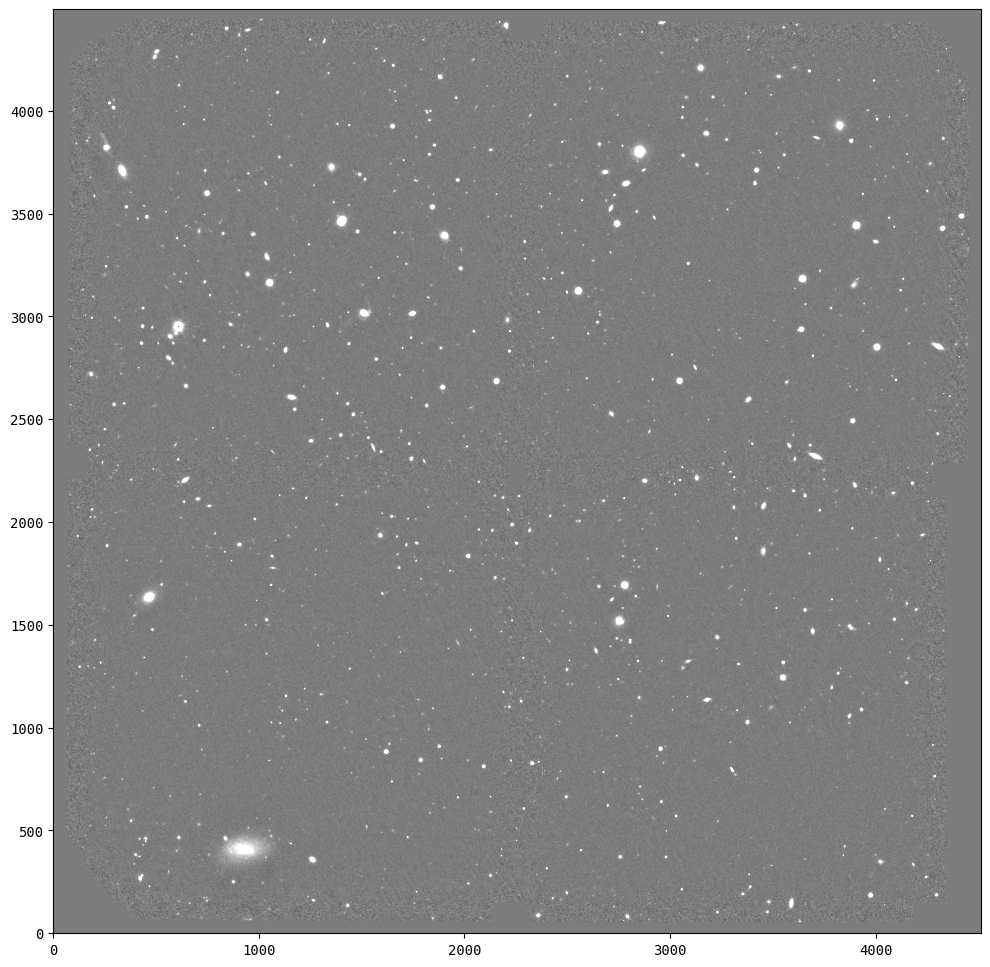

In [2]:
m, s = np.mean(data), np.std(data)
fig,ax=plt.subplots(figsize=(12,12))
im = ax.imshow(data,vmin=m-s, vmax=m+s, origin='lower')

In [3]:
# FIND PEAKS
peaks_tbl = find_peaks(data, threshold=400.0)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  

df = peaks_tbl.to_pandas().sort_values(by='x_peak')
# search and remove sources with same x values, keeping only first finds
dups = df.duplicated(subset="x_peak",keep="first")
nodups = df[~dups]

#elimiating overlapping sources
proximity_threshold = 20
filteredDF = nodups.groupby(nodups['x_peak'] // proximity_threshold * proximity_threshold).apply(
    lambda group: group.loc[group['peak_value'].idxmax()])

peaks_tbl = filteredDF
print(peaks_tbl) 


        x_peak  y_peak   peak_value
x_peak                             
320      336.0  3708.0   502.894226
460      467.0  1634.0   768.790466
600      610.0  2955.0  1512.410889
740      748.0  3599.0  2067.033936
1040    1056.0  3163.0  1804.180054
1380    1397.0  3461.0   858.114929
1400    1400.0  3455.0  1472.878296
1480    1481.0  3413.0   405.380676
1620    1620.0   882.0   982.681335
1640    1651.0  3925.0   846.318665
1740    1742.0  2308.0   407.766968
1780    1788.0   841.0   581.428223
1840    1845.0  3532.0  1164.526611
1880    1895.0  2655.0  1375.345093
2000    2019.0  1834.0   796.126526
2080    2095.0   811.0   454.746765
2140    2157.0  2685.0  2682.163086
2320    2330.0   826.0   666.697510
2540    2555.0  3127.0  1899.814575
2740    2743.0  3453.0  2728.930908
2760    2777.0  1695.0   621.855652
2780    2780.0  1689.0  1450.648804
2940    2954.0   896.0   626.330811
3040    3047.0  2685.0  2703.618408
3360    3377.0  1025.0   627.800476
3420    3421.0  3711.0   900

(0.0, 4494.0)

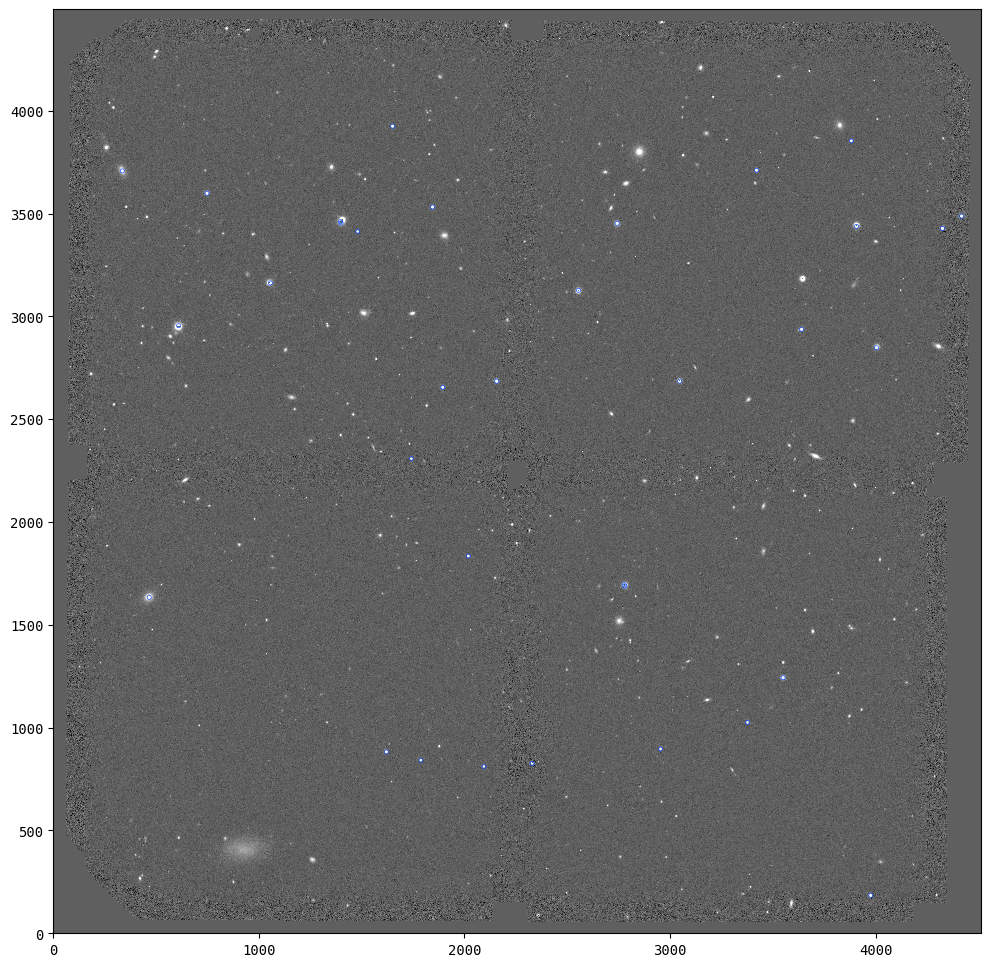

In [4]:
# marking sources using apertures
tbl = peaks_tbl
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=10.0)
norm = simple_norm(data, 'sqrt', percent=99.9)
plt.figure(figsize=(12,12))
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='#0547f9', lw=0.5)
plt.xlim(0, data.shape[1] - 1)
plt.ylim(0, data.shape[0] - 1)

In [4]:
# size of a star cutout
size = 35
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
# remove stars that are too close to edges
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))  

In [5]:
# make table of stars
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]
# drop rows for different brightness thresholds
droprows50 = [0,2,3,16,26,31,33,34,37,55,59,62,63,65,66,67,68,71,72,77,78,79,84,87,102,108,118,120,122,123,124,128,129,133,134,135,137]
droprows500 = [2,4,5,6,14,15,16,17,18,20,25,27]
droprows400 = [2,4,5,6,17,18,19,20,21,23,29,31]
stars_tbl.remove_rows(droprows400)

a=[0,1,4,17]
stars_tbl.remove_rows(a)
stars_tbl

x,y
float64,float64
748.0,3599.0
1481.0,3413.0
1651.0,3925.0
1742.0,2308.0
1788.0,841.0
1845.0,3532.0
1895.0,2655.0
2019.0,1834.0
2095.0,811.0


In [16]:
#subtract background
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)  
data -= median_val  
#extract star stamps
nddata = NDData(data=data)
stars = extract_stars(nddata, stars_tbl, size=size) 
# build psf
epsf_builder = EPSFBuilder()  
epsf, fitted_stars = epsf_builder(stars)  

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

EPSFBuilder converged after 5 iterations (of 10 maximum iterations)


"\nhdu = fits.PrimaryHDU(epsf1.data)\nhdulist = fits.HDUList([hdu])\nfilename = 'psf1.fits'\nhdulist.writeto(filename, overwrite=True)\n"

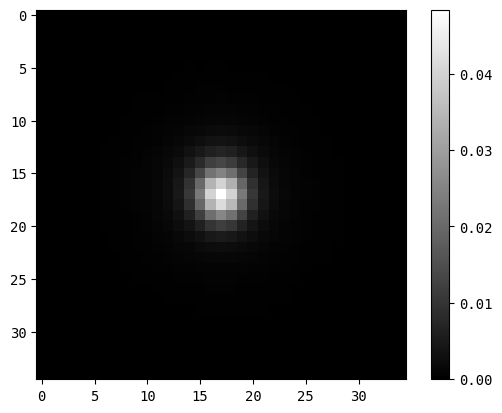

In [33]:
epsf_builder1 = EPSFBuilder(oversampling=1,shape=(35,35))  
epsf1, fitted_stars1 = epsf_builder1(stars) 
plt.imshow(epsf1.data)
plt.colorbar()
"""
hdu = fits.PrimaryHDU(epsf1.data)
hdulist = fits.HDUList([hdu])
filename = 'psf1.fits'
hdulist.writeto(filename, overwrite=True)
"""

In [8]:
EPSFBuilder?

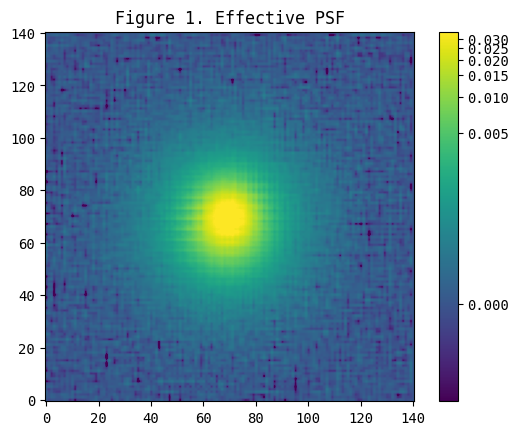

In [7]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm,origin='lower', cmap='viridis')
plt.colorbar()
plt.title("Figure 1. Effective PSF");

[(-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (-0.5, 34.5, -0.5, 34.5),
 (0.0, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0)]

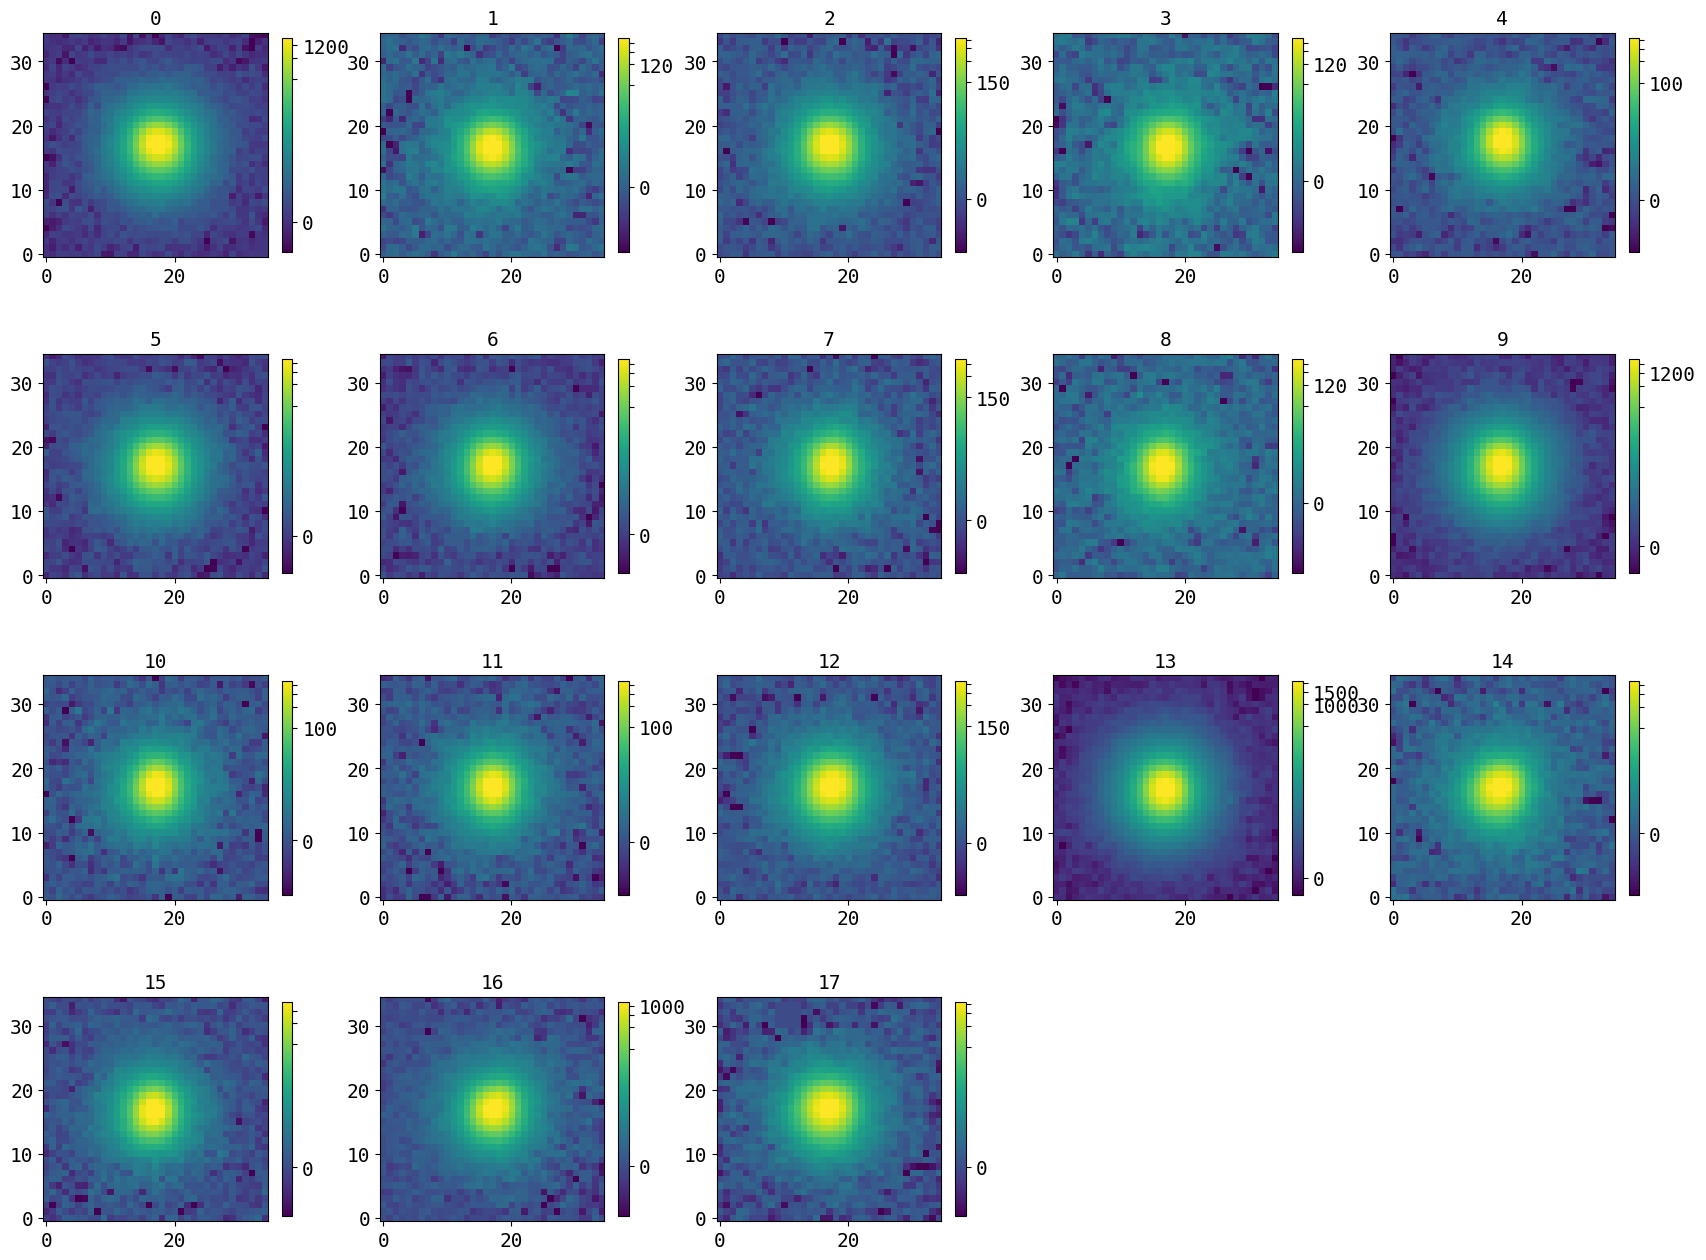

In [34]:
# plotting the stars used to make psf
medium_font_size = 14 

# Set the font size for various text elements
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size
from matplotlib.ticker import LogFormatter
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 16),
                       squeeze=True)
ax = ax.ravel()
for i in range(len(stars)):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(i)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax[i], format=LogFormatter(labelOnlyBase=False), shrink=0.8)
    colorbar.ax.yaxis.set_major_locator(plt.MaxNLocator(5))




In [19]:
from skimage.transform import resize

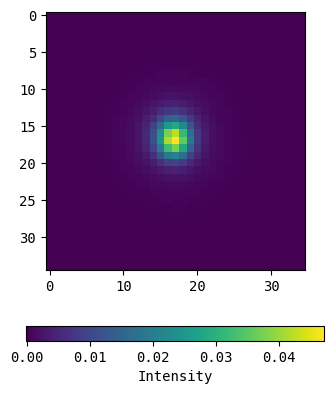

In [20]:
# resizing psf image
epsf35 = resize(epsf.data, (35,35))
plt.imshow(epsf35,cmap='viridis')
cbar = plt.colorbar(orientation="horizontal", shrink=0.6)
cbar.set_label('Intensity');

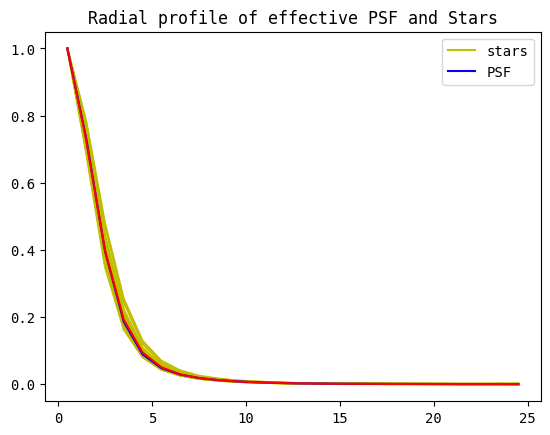

In [24]:
# plotting radial profiles
fig = plt.figure()
legend_handles = [plt.Line2D([], [], color='y', label='stars'),plt.Line2D([], [], color='b', label='PSF')]
#profiles of stars    
for i in range(len(stars)):
    rp_star = profiles.RadialProfile(stars[i].data,xycen=stars[i].cutout_center,radii=np.arange(70))
    rp_star.normalize("max")
    plt.plot(rp_star.radius, rp_star.profile, color='y')
# profile of psf   
rp_psf = profiles.RadialProfile(epsf1.data,xycen=(17,17),radii = np.arange(70))
rp_psf.normalize("max")
plt.plot(rp_psf.radius, rp_psf.profile,"b")

rp_psf = profiles.RadialProfile(epsf35,xycen=(17,17),radii = np.arange(70))
rp_psf.normalize("max")
plt.plot(rp_psf.radius, rp_psf.profile,"r-")

plt.legend(handles=legend_handles)
plt.title("Radial profile of effective PSF and Stars");

In [13]:
# save psf to fits file
hdu = fits.PrimaryHDU(epsf.data)
hdulist = fits.HDUList([hdu])
filename = 'epsf2.fits'
#hdulist.writeto(filename, overwrite=True)

## tests with scaled psf from epsf.evaluate

''

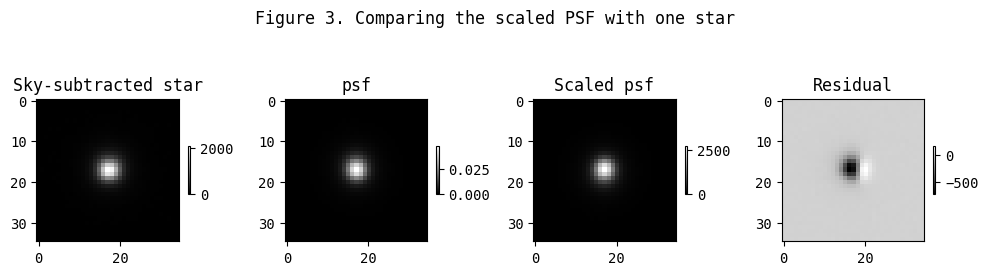

In [26]:
# make scaled psf with same size as star
x, y = np.meshgrid(np.arange(35), np.arange(35))
y = np.flipud(y)
psf = epsf1.evaluate(x=x, y=y, flux=np.sum(stars[0].data), x_0=17, y_0=17)
fig, ax = plt.subplots(1, 4,figsize=(10,3))

im0 = ax[0].imshow(stars[0].data)
im1 = ax[1].imshow(epsf1.data)
im2 = ax[2].imshow(psf)
im3 = ax[3].imshow(stars[0].compute_residual_image(epsf1))


for im, ax, tit in zip([im0, im1, im2, im3], [ax[0], ax[1], ax[2], ax[3]], ['Sky-subtracted star', "psf", 'Scaled psf', 'Residual']):
    cbar = fig.colorbar(im, ax=ax, shrink=0.2)
    ax.set_title(tit)
fig.suptitle("Figure 3. Comparing the scaled PSF with one star")
fig.tight_layout()
;


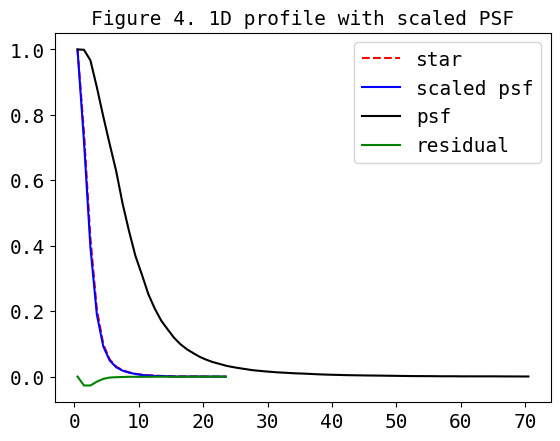

In [15]:
rp_star = profiles.RadialProfile(stars[0].data,xycen=stars[0].cutout_center,radii=np.arange(25))
rp_star.normalize("max")
plt.plot(rp_star.radius, rp_star.profile, '--r',label="star")


rp_starr = profiles.RadialProfile(psf,xycen=stars[0].cutout_center,radii=np.arange(25))
rp_starr.normalize("max")
plt.plot(rp_starr.radius, rp_starr.profile, color='b', label="scaled psf")

rp_psf = profiles.RadialProfile(epsf.data,xycen=(70,70),radii = np.arange(72))
#rp_psf.normalize("max")
plt.plot(rp_psf.radius, rp_psf.profile/np.max(rp_psf.profile),"k",label="psf")


plt.plot(rp_starr.radius, rp_starr.profile-rp_star.profile, "g",label="residual")
plt.title("Figure 4. 1D profile with scaled PSF")

plt.legend();

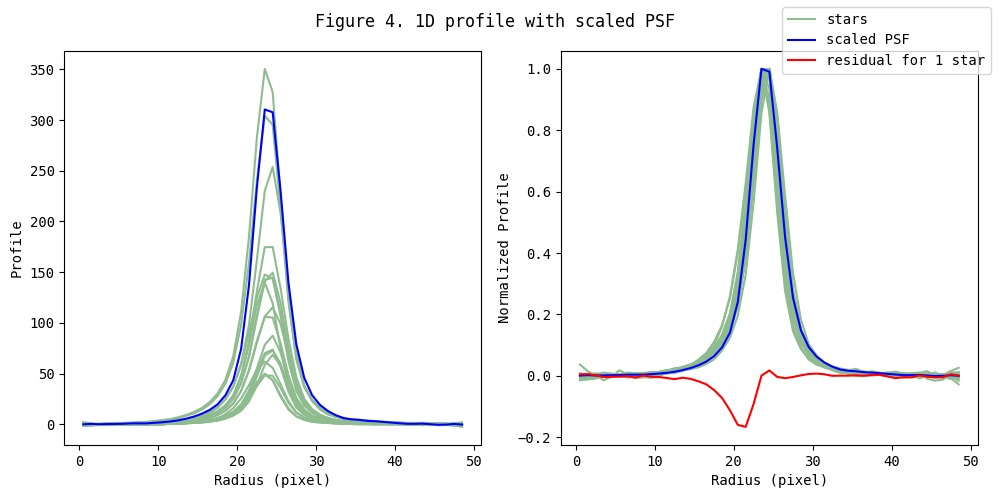

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(len(stars)):
    rp_star = profiles.RadialProfile(stars[i].data,xycen=(0,0),radii=np.arange(140))
    ax[0].plot(rp_star.radius, rp_star.profile, 'darkseagreen',label="star")
    rp_star.normalize("max")
    ax[1].plot(rp_star.radius, rp_star.profile, 'darkseagreen',label="star")

#scaled psf
rp_starr = profiles.RadialProfile(psf,xycen=(0,0),radii=np.arange(140))
ax[0].plot(rp_starr.radius, rp_starr.profile, color='b', label="scaled psf")
rp_starr.normalize("max")
ax[1].plot(rp_starr.radius, rp_starr.profile, color='b', label="scaled psf")

# real epsf
rp_psf = profiles.RadialProfile(epsf.data,xycen=(0,0),radii = np.arange(140))
rp_psf.normalize("max")
#plt.plot(rp_psf.radius, rp_psf.profile/np.max(rp_psf.profile),"k",label="psf")


plt.plot(rp_starr.radius, rp_starr.profile-rp_star.profile, "r")
fig.suptitle("Figure 4. 1D profile with scaled PSF")
legend_handles = [plt.Line2D([], [], color='darkseagreen', label='stars'),plt.Line2D([], [], color='b', label='scaled PSF'),plt.Line2D([], [], color='r', label='residual for 1 star')]
[ax[i].set_xlabel("Radius (pixel)") for i in range(2)]
ax[0].set_ylabel("Profile")  
ax[1].set_ylabel("Normalized Profile") 
fig.legend(handles=legend_handles)
fig.tight_layout();

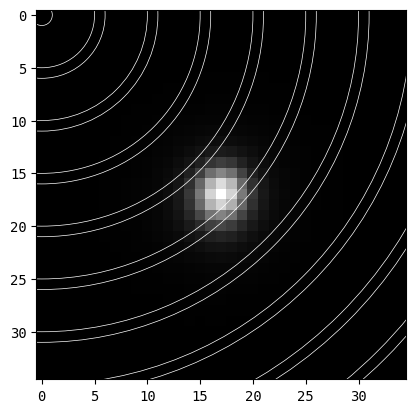

In [29]:
plt.imshow(psf)
[rp_starr.apertures[int(5*i)].plot(color='white', lw=0.5) for i in range(10)];

In [17]:
# saving a star profile as the psf
hdu = fits.PrimaryHDU(stars[0].data)
hdulist = fits.HDUList([hdu])
filename = 'star0.fits'
hdulist.writeto(filename, overwrite=True)